In [1]:
%run ./functions_gandalf_skywalker_20210822.ipynb
%run ./engine_gandalf_skywalker_20220106.py
%run ./Genera_LIB_V5.ipynb

5.3.1


In [2]:
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,noise,pct_noise):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    if noise == 1:
        print("AGGIUNGO RUMORE")
        dataset=add_noise(dataset.open, dataset.high, dataset.low, dataset.close,dataset.volume, pct_noise)

    dataset = dataset.loc[IS:OOS]
    dataset["dayofweek"] = dataset.index.dayofweek
    dataset["day"] = dataset.index.day
    dataset["month"] = dataset.index.month
    dataset["year"] = dataset.index.year
    dataset["dayofyear"] = dataset.index.dayofyear
    dataset["week"] = dataset.index.week
    dataset["hour"] = dataset.index.hour
    dataset["minute"] = dataset.index.minute
    dataset["daily_open"] = daily_open(dataset,1)
    dataset["daily_high"] = daily_high(dataset,1)
    dataset["daily_low"] = daily_low(dataset,1)
    dataset["daily_close"] = daily_close(dataset,1)
    dataset["AVGPRICE"]=ta.AVGPRICE(dataset.open, dataset.high, dataset.low, dataset.close)
    dataset["MEDPRICE"]=ta.MEDPRICE(dataset.high, dataset.low)
    dataset["TYPPRICE"]=ta.TYPPRICE(dataset.high, dataset.low, dataset.close)
    dataset["WCLPRICE"]=ta.WCLPRICE(dataset.high, dataset.low, dataset.close)
    history=dataset.copy()
    
    print("Carico indicatori")

    
    #import legitindicators

    """data_filter=dataset.iloc[:].copy()
    for e in data_filter.columns:
        data_filter[e]= legitindicators.super_smoother(data_filter[e], 10)"""
    
    #import talib as ta
    #ATR = ta.ATR(dataset.high,dataset.low,dataset.close,5)
    #ATR = ATR.fillna(0)
    #dataATR=dataset.copy()
    #for e in dataATR.columns:
        #dataATR[e]=dataATR[e]/ATR
        
        
        
    dataset , log_price =apply_log_price(dataset)
    dataset=dataset.fillna(method="ffill")
    dataset=dataset.fillna(0)
    
    global GENETIC_POOL , MAX_OFFSET 
    GENETIC_POOL = log_price 
    MAX_OFFSET = 4    
        
        
    applica_indicatori=apply_indicator(dataset)
    dataset=applica_indicatori[0]
    dataset_ind = dataset#.iloc[:,21:].copy()


    rules=dataset.T.values
    rule_formulas=np.arange(len(rules))
    
    history.tail(10)
    
    history.close.plot(figsize=(20,10),title=SIMBOLO+"_"+RESAMPLE_TF)
    print("Fatto")
    return dataset , dataset_ind , history , rules, rule_formulas

In [3]:
def apply_log_price(dataset):
    
    log_price=["OpenToLowLog",
    "OpenToAvgPriceLog",
    "OpenToMedPriceLog",
    "OpenToOpenLog",
    "OpenToMedBodyPriceLog",
    "CloseToMedPriceLog",
    "CloseToCloseLog",
    "CloseToLowLog",
    "CloseToAvgPriceLog",
    "CloseToMedBodyPriceLog",
    "HighToCloseLog",
    "HighToOpenLog",
    "HighToMedBodyPriceLog",
    "HighToMedPriceLog",
    "HighToAvgPriceLog",
    "HighToHighLog",
    "LowToLowLog",
    "AvgPriceToMedPriceLog",
    "AvgPriceToLowLog",
    "AvgPriceToAvgPriceLog",
    "AvgPriceToMedBodyPriceLog",
    "MedPriceToLowLog",
    "MedBodyPriceToLowLog",
    "MedPriceToMedBodyPriceLog",
    "MedPriceToMedPriceLog",
    "MedBodyPriceToMedBodyPriceLog",
    "RangeLog",
    "BodyLog",
    "BodyToRangeLog"]

    for e in log_price:
        dataset[e]=eval(e+"(dataset)")
        
    return dataset , log_price


def generate_rule(dataset, element1, offset1, element2, offset2):
    """
    Funzione che genera una regola (colonna del Pandas DataFrame) 
    del tipo element1(offset) > element2(offset)
    """
    return dataset[element1].shift(offset1) > dataset[element2].shift(offset2)

def generate_rule_formula(element1, offset1, element2, offset2):
    """
    Funzione che genera la formula associata "element1(offset) > element2(offset)"
    """
    return "("+element1 + "(dataset).shift(" + str(offset1) + ") > " + element2 + "(dataset).shift(" + str(offset2) + "))"

def apply_indicator(dataset):
    """
    Funzione che genera la matrice delle regole booleane
    e tutte le formule associate "element1(offset) > element2(offset)"
    """
    
    rules = pd.DataFrame()
    rule_formulas = []
    i = 0
    for element1 in tqdm(GENETIC_POOL):
        for offset1 in range(1, MAX_OFFSET + 1):   #### modifica 0 
            for element2 in GENETIC_POOL:
                for offset2 in range(1, MAX_OFFSET + 1): #### modifica 0 
                    if (element1 != element2) | (offset1 != offset2):
                        rule = eval(generate_rule_formula(element1, offset1, element2, offset2))
                        if not (np.all(rule == 0) | np.all(rule == 1)):
                            rules[i] = rule
                            rule_formulas.append(generate_rule_formula(element1, offset1, element2, offset2))
                            i += 1
                            
    rules.columns=rule_formulas
    return rules, rule_formulas



In [4]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API")

In [5]:
def info_simboli():
    import os
    import numpy as np
    import pandas as pd

    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    print("Calcolo Min Avg Trade per mercato...")
    ls_lp , ls_std = last_price_std(valori)
    valori["Last_Price"] = ls_lp
    valori["Standard_Deviation"] = ls_std 
    valori["Min_Avg_Trade"] = (valori.BigPointValue*valori.Last_Price)
    valori["Min_Avg_Trade"] = (valori["Min_Avg_Trade"]*0.0006).round()  ##### delta x modificare min avg trade
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori


os.chdir(dir_home)
valori=info_simboli()

valori

Calcolo Min Avg Trade per mercato...


  0%|          | 0/27 [00:00<?, ?it/s]

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,...,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo,Last_Price,Standard_Deviation,Min_Avg_Trade
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,...,1400,0.000100,25,DA6,CST6CDT,6A,AD,0.67405,0.089246,40.0
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,...,1400,0.000100,25,BP6,CST6CDT,6B,BP,1.19130,0.158153,45.0
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,...,1430,0.010000,50,CLE,EST5EDT,CL,CL,102.83000,29.720852,62.0
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,...,1400,0.000100,25,EU6,CST6CDT,6E,EC,1.00940,0.125934,76.0
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,...,1515,0.250000,25,EP,CST6CDT,ES,ES,3858.00000,944.833453,116.0
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,...,2200,0.500000,50,FDX,CET,FDAX,FDAX,12824.00000,2503.541585,192.0
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,...,2200,0.500000,20,DSX,CET,FESX,FESX,3460.00000,795.870558,10.0
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,...,2200,0.010000,20,DB,CET,FGBL,FGBL,151.27000,21.008999,91.0
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,...,1500,0.100000,60,GCE,EST5EDT,GC,GC,1731.90000,210.684785,104.0
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,...,1500,0.050000,60,CPE,EST5EDT,HG,HG,3.42500,0.616178,51.0


# Carico Dati e Indicatori STANDARD

Caricato storico
Resample dei dati
Carico indicatori


  0%|          | 0/29 [00:00<?, ?it/s]

Fatto


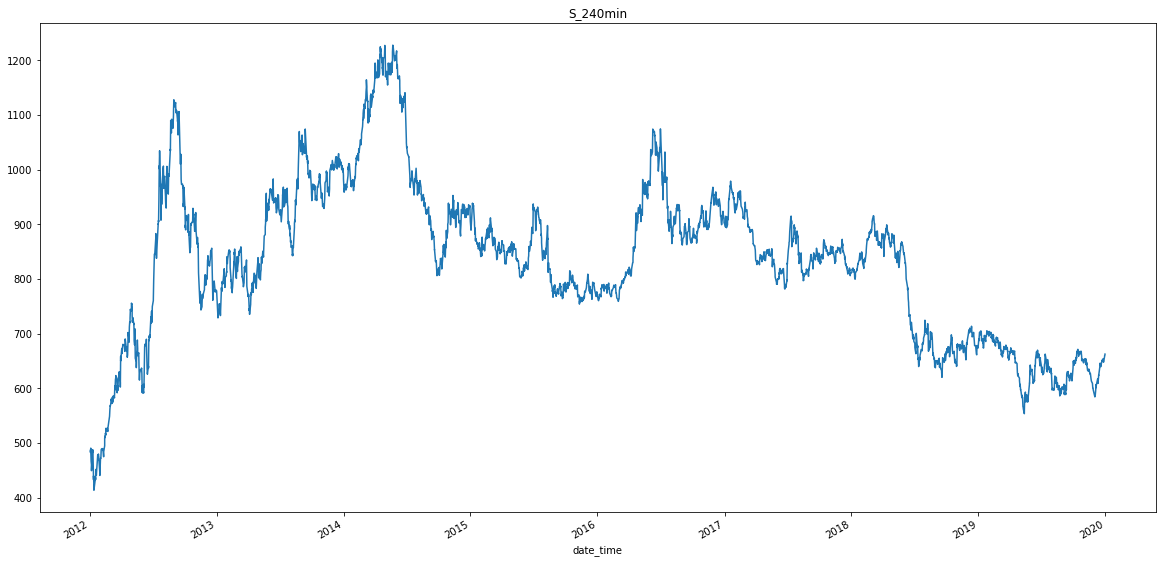

In [25]:

SIMBOLO = "S"

TYPE_SESSION = 1    
RESAMPLE_TF = "240min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2012-01-01"
END_DATE = "2020-01-01"


dataset , dataset_ind , history , rules, rule_formulas , bigpointvalue , tick , utc_offset , custom_session_start ,\
custom_session_stop , Costi = environment(SIMBOLO,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)

In [26]:
def fitness(dna0):
    
    tmp0 = eval(dna_formula(dna0))
    tf0 = strategy(tmp0,exit,target_monetario,costi,level_check,tipo_ordine,ADD_RULE)

    
    
    if (len(tf0[tf0!=0])>min_n_operazioni) & (len(tf0[tf0!=0])<max_n_operazioni):
        if GSA == 1:
            sum_strategy=tf0+second_np
            
            TST=np.array_split(sum_strategy, n_part)
            tf=np.concatenate(TST[p_d::2])
            tf=pd.Series(data=tf[tf!=0])
            
            if n_str!= 0:
                TST=np.array_split(tf0, n_part)
            if p_d == 1:
                p_d1=2
            else:
                p_d1=1

            tf_os=np.concatenate(TST[p_d1::2])
            tf_os=pd.Series(data=tf_os[tf_os!=0])
        else:
            sum_strategy=tf0+second_np
            sum_strategy=sum_strategy[sum_strategy!=0]
            tf=pd.Series(data=sum_strategy)

            
        if ranking == "avg_trade":
            gain=avg_trade(tf)
            
        if ranking == "profit_factor":
            gain=profit_factor(tf)
            
        if ranking == "percent_win":
            gain=percent_win(tf)
            
        if ranking == "profit":
            gain=tf.sum()
            
        if ranking == "win":
            gain=percent_win(tf)
            
        if ranking == "profit/SQRT(std_return)":
            gain=tf.sum()/np.sqrt(tf.std())
            
        if ranking == "kestner":
            gain=kestner_ratio_mod(tf)
            
        if ranking == "avg_trade/max_dd":
            gain=(avg_trade(tf)/max_draw_down(tf.cumsum()))*(-1)
            
        if ranking == "(avg_trade * netprofit)/std_return":
            gain=((avg_trade(tf)*tf.sum())/tf.std())*(-1)
            
        if ranking == "SQRT(n_trade)*avg_trade":
            gain=np.sqrt(len(tf))*avg_trade(tf)
            
        if ranking == "SQRT(n_trade)*avg_trade/STD":
            gain=((np.sqrt(len(tf))*avg_trade(tf))/tf.std())   #*skew(tf.values)
            
        if ranking == "kestner_2":
            gain=((np.sqrt(len(tf))*avg_trade(tf))/tf.std()) * (kestner_ratio_mod(tf)*2)
            
        if ranking == "coef_angolare":    
            gain = (np.rad2deg(np.arctan2(tf.sum() , len(tf)))) 
           
        if ranking == "sharpe_ratio":
            gain = old_sharpe_ratio(tf.values)
            
        if ranking == "profit/max_gain":
            gain = tf.sum()/max_gain(tf)
            
            
        if GSA == 1:
            if (gain != np.nan) & (tf.sum()>0) :#& (avg_trade(tf_os)>70) & (avg_trade(tf)>70) : 
            #if (profit_factor(tf_os)>2) & (profit_factor(tf)>2): 
                return gain    
            else:
                return 0#-1000000000
        else:
            if (gain != np.nan) & (tf.sum()>0) : 
                return gain    
            else:
                return 0#-1000000000
            
    else:
        return 0#-1000000000

    
def print_best(population, gen_num):
    if STAMPA_GENERAZIONE ==1:

        tmp=eval(dna_formula(population[0]))
        tf0 = strategy(tmp,exit,target_monetario,costi,level_check,tipo_ordine,ADD_RULE)
        
        if len(tf0[tf0!=0])>min_n_operazioni:
            if GSA == 1:
                clear_output(wait=True)

                figure, axis = plt.subplots(2, 2,figsize=(10,10))
                tf=pd.DataFrame({"Evolving System":tf0,"Previous System":second_np})


                TST=np.array_split(tf , n_part)
                n_ls=list(range(n_part))[p_d::2]
                l_lst=[]
                for nls in n_ls:
                    l_lst.append([TST[nls].index[0],TST[nls].index[-1]])



                a0=tf.cumsum()
                axis[0, 1].plot(a0)
                axis[0, 1].set_title("Evoluzione Strategia:"+direzione+" "+tipo_ordine+" "+str(gen_num))

                a1=tf.cumsum().sum(axis=1)
                axis[0, 0].plot(a1)
                axis[0, 0].set_title("SYSTEM "+str(gen_num)+" "+SIMBOLO+" "+ranking)


                for ln in range(len(l_lst)):
                    if ln != len(l_lst)-1:
                        a2,a2b=l_lst[ln][0], l_lst[ln][-1]
                        axis[0, 0].axvspan(a2,a2b,alpha=0.2, color='red',label ="")
                    else:
                        a3,a3b=l_lst[ln][0], l_lst[ln][-1]
                        axis[0, 0].axvspan(a3,a3b,alpha=0.2, color='red',label ="IS")


                a=np.array_split(tf0, n_part)
                if p_d == 2:
                    a=a[::2]
                else:
                    a=a[1::2]
                a=np.concatenate(a)


                b=np.array_split(tf0, n_part)
                if p_d == 1:
                    b=b[::2]
                else:
                    b=b[1::2]
                b=np.concatenate(b)

                a4=pd.Series(index=list(range(len(a))),data=a).cumsum()
                axis[1, 0].plot(a4)
                axis[1, 0].set_title("IN SAMPLE")
                a5=pd.Series(index=list(range(len(b))),data=b).cumsum()
                axis[1, 1].plot(a5)
                axis[1, 1].set_title("OUT OF SAMPLE")

                plt.tight_layout()
                plt.show()
            else:
                clear_output(wait=True)

                figure, axis = plt.subplots(2, 2,figsize=(10,10))
                tf=pd.DataFrame({"Evolving System":tf0,"Previous System":second_np})
                
                
                a0=tf.cumsum()
                axis[0, 1].plot(a0)
                axis[0, 1].set_title("Evoluzione Strategia:"+direzione+" "+tipo_ordine+" "+str(gen_num))

                a1=tf.cumsum().sum(axis=1)
                axis[0, 0].plot(a1)
                axis[0, 0].set_title("SYSTEM "+str(n_str)+" "+SIMBOLO+" "+ranking)
                
                plt.tight_layout()
                plt.show()
        return 

In [27]:
def genera_livello(tipo_ordine,direzione,rolling_random_period):
    
    rolling_random_period=str(rolling_random_period)
    
    if (tipo_ordine == "stop") & (direzione == "long") :
        return 'history.high.rolling('+rolling_random_period+').max().shift(1)'
    
    if (tipo_ordine == "stop") & (direzione == "short") :
        return 'history.low.rolling('+rolling_random_period+').min().shift(1)'
    
    if (tipo_ordine == "limit") & (direzione == "short") :
        return 'history.high.rolling('+rolling_random_period+').max().shift(1)'
    
    if (tipo_ordine == "limit") & (direzione == "long") :
        return 'history.low.rolling('+rolling_random_period+').min().shift(1)'
    
    if tipo_ordine == "market" :
        return 'history.close.shift(1)'
    


def remove_outlier(y):
    Q1 = np.percentile(y, 45,
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 55,
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    #y[y>=Q3+1.5*IQR]=0
    #y[y<=Q1-1.5*IQR]=0
    return y


In [29]:
def target(direzione,_search,dataset):

    price=dataset.open.copy()
    t_m=[]
    t_m=price.shift(-_search)-price
    #t_m=remove_outlier(t_m)
    t_m=t_m.shift(-1)
    t_m=t_m.fillna(0)
    if direzione == "long":
        t_m=np.array(t_m * bigpointvalue)
    else:
        t_m=t_m*(-1)
        t_m=np.array(t_m * bigpointvalue)
    return t_m

Strategia OK salvo in DataFrame
generations in 26.347193956375122 seconds


<AxesSubplot:>

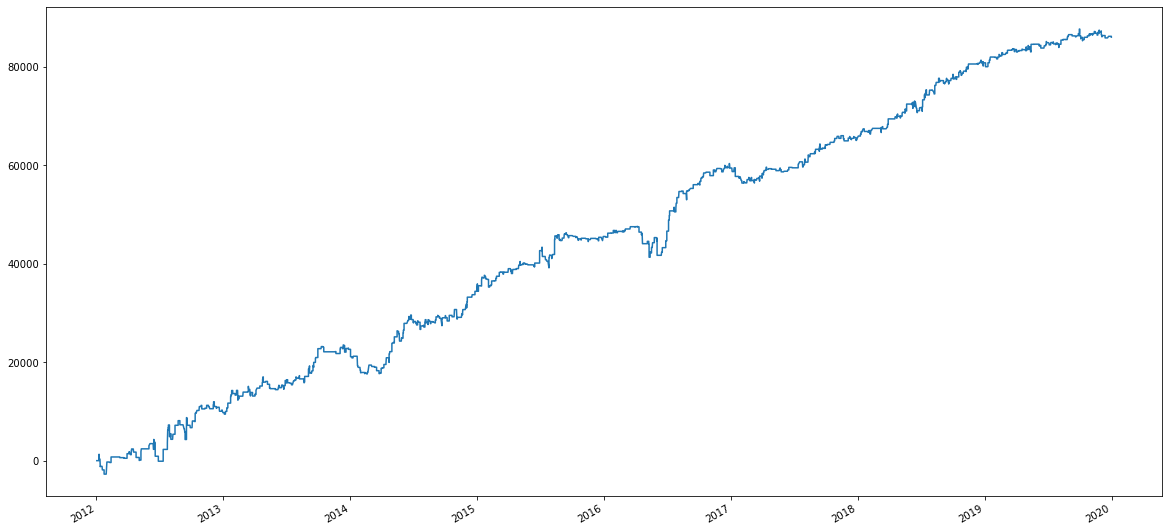

In [38]:

STD_DAILY_MAX = 100000
OTTIMIZZA_TP_SL_SECOND = True

#for num_strat in range(10):

from IPython.display import clear_output
import timeit
import random 

ls_direzione=random.choice(["long","short"])  
ls_direzione="long"
second_np=pd.Series(index=dataset_ind.index,data=0)
second_s=pd.Series(index=dataset_ind.index,data=0)
n_str=0
csv_full=pd.DataFrame()

direzione=ls_direzione

while True:

    clear_output(wait=True)
    random.seed(a=None, version=2)

    start_time = time.time()

    GSA = 0
    STAMPA_GENERAZIONE = 1
    NUM_GENERATIONS = 30
    BEST_DNA_RATIO = 0.2 #0.1 - 0.3
    CROSS_DNA_RATIO = 0.2 #0.1 - 0.3
    DNA_SIZE_min = 2
    DNA_SIZE_max = 4
    POPULATION_SIZE = 500

    costi=0#costi
    tipo_ordine=random.choice(["market","stop","limit"])

    rolling_random_period= random.randint(1, 6)
    level = genera_livello(tipo_ordine,direzione,rolling_random_period)
    exit_min = 1
    exit_max = 4
    min_n_operazioni = 400
    max_n_operazioni = 5000
    ranking = "SQRT(n_trade)*avg_trade/STD" #"SQRT(n_trade)*avg_trade" #profit_factor #percent_win #profit
    if n_str >= 1:
        ranking = "kestner_2"

    min_gain_in_OOS = 0
    
    if direzione == "short":
        ADD_RULE_CONDITION = "False"  #"faster_supertrend_talib(history.high.values, history.low.values, history.close.values, period=5, multiplier=9)[1].astype(bool)" #"False" #add_rule_long
    if direzione == "long":
        ADD_RULE_CONDITION = "False"  #"(faster_supertrend_talib(history.high.values, history.low.values, history.close.values, period=5, multiplier=9)[1]*(-1)).astype(bool)" #"False" #add_rule_short

    n_part=random.randint(50, 50) #10,20
    p_d=random.randint(1, 2)

    DNA_SIZE = random.randint(DNA_SIZE_min, DNA_SIZE_max)
    ADD_RULE = check_add_rule(ADD_RULE_CONDITION,history)

    if tipo_ordine != "market":
        level_check = check_level(level,direzione,tipo_ordine)
    else:
        level_check = np.array([True]*len(history))

    exit=random.randint(exit_min, exit_max)
    target_monetario=target(direzione,exit,history)
    best_dnas = evolution()

#################################################################################################
    #clear_output(wait=True)
    best_dna=best_dnas[check_best_dna(best_dnas)]
    results = pd.DataFrame()
    csv_export = pd.DataFrame()
    avg_trade_min = Costi*2 # #valori["Min_Avg_Trade"][valori.Physical==SIMBOLO].values[0]#+valori["Cost"][valori.Physical==SIMBOLO].values[0]
    n_operations_min = min_n_operazioni
    take_p = 0
    stop_l = 0

    dna_check=dna_formula_dataframe(best_dna)
    exit_bars=exit
    trade_list=strategy_numba(dna_check,bigpointvalue,tick,costi,direzione,exit_bars,level,tipo_ordine,take_p,stop_l,history,ADD_RULE_CONDITION)
    if (len(trade_list)>1):
        check_std=trade_list.resample("D").sum()
        check_std=check_std[check_std!=0].dropna()
        if (check_std.std() < STD_DAILY_MAX) & (skew(check_std.values)>0.1):
            print("VALIDATION NUMBA - MIN AVG TRADE...")
            report=performance_report_gen(trade_list)
            results=pd.concat([results,report])
            display(report)
            trade_list.cumsum().plot(figsize=(10,10))
            plt.show()
            print("")
            print("")

            if (report.AverageTrade[0]>avg_trade_min) & (report.Operations[0] > n_operations_min):
                info=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,direzione,tipo_ordine,traduci(dna_check),exit,level,ADD_RULE_CONDITION]).T
                csv_export=pd.concat([csv_export,info])

                csv_export.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION"])

            ##################################################################################################
                #clear_output(wait=True)
     
                print("OTTIMIZZAZIONE TP E SL...")             

                v_std=trade_list.std()
                v1=np.arange(v_std,v_std*10,int(v_std*0.5)) #TP
                v2=np.arange(v_std,v_std*10,int(v_std*0.5)) #SL
                results=pd.DataFrame()
                for e in tqdm(v1):
                    for j in v2:
                        trade_list=strategy_numba(dna_check,bigpointvalue,tick,costi,direzione,exit_bars,level,tipo_ordine,int(e),int(j),history,ADD_RULE_CONDITION)

                        if OTTIMIZZA_TP_SL_SECOND == True :
                            trade_list.add(second_s, fill_value=0)

                        report=performance_report_gen(trade_list)
                        report["TP"]=int(e)
                        report["SL"]=int(j)
                        results=pd.concat([results,report])

                results["TP_SP_Ratio"]=results.TP/results.SL

                res=results.sort_values(by=["KestnerRatio","AverageTrade","MaxDD"],ascending=[False,False,False])

                if tipo_ordine == "limit":
                    res=res[res.TP_SP_Ratio>0.5]

                if tipo_ordine == "stop":
                    res=res[res.TP_SP_Ratio>1]

                if tipo_ordine == "market":
                    res=res[res.TP_SP_Ratio>0.75]   

                take_p = res.TP.iloc[0]
                stop_l = res.SL.iloc[0]


                trade_list=strategy_numba(dna_check,bigpointvalue,tick,costi,direzione,exit_bars,level,tipo_ordine,take_p,stop_l,history,ADD_RULE_CONDITION)
                report=performance_report_gen(trade_list)
                report["TP"]=take_p
                report["SL"]=stop_l
                results=pd.concat([results,report])
                display(report)
                trade_list.cumsum().plot(figsize=(10,10))
                plt.show()
            ###############################################################################################################################
                #clear_output(wait=True)
                if False:
                    o_TIME_EXIT = exit
                    o_MONEY_STOPLOSS = stop_l
                    o_MONEY_TAKEPROFIT = take_p
                    o_enter_level = eval(level)
                    o_enter_rules = eval(dna_check) & level_to_condition(level,history,tipo_ordine,direzione) & check_add_rule(ADD_RULE_CONDITION,history)
                    o_kestner= kestner_ratio(trade_list)
                    delta_SL=o_MONEY_STOPLOSS*20//100
                    delta_TP=o_MONEY_TAKEPROFIT*20//100

                    print("VALIDAZIONE PARAMETRI...")
                    cnt_val=0
                    for vl in tqdm(range(100)):

                        v1 = o_TIME_EXIT+random.randint(1,2)  
                        v2 = o_MONEY_STOPLOSS+random.randint(-delta_SL,delta_SL)
                        v3 = o_enter_level.shift(random.randint(1,2)).fillna(0)
                        v4 = o_enter_rules.shift(random.randint(1,2)).fillna(False)
                        v5 = o_MONEY_TAKEPROFIT+random.randint(-delta_TP,delta_TP)

                        Y_VAL= strategy_numba_val(v4,bigpointvalue,tick,0,v3,tipo_ordine,v2,direzione,v1,v5)
                        Y_VAL.cumsum().plot()
                        cnt_val=cnt_val+(kestner_ratio(Y_VAL))

                    trade_list.cumsum().plot(linewidth=7.0,figsize=(10,10),color="red")
                    plt.show()
                    if (cnt_val/100)>=(o_kestner/1.3):
                        print("VALIDAZIONE OK",(cnt_val/100),(o_kestner/1.3))
                        validazione_parametri=1
                    else:
                        print("VALIDAZIONE KO",(cnt_val/100),(o_kestner/1.3))
                        validazione_parametri=0

            #####################################################################################################################################
                #clear_output(wait=True)
                #if validazione_parametri >= 1:
                if True:
                    print("VALIDAZIONE NOISE...")
                    trade_list=strategy_numba(dna_check,bigpointvalue,tick,costi,direzione,exit_bars,level,tipo_ordine,take_p,stop_l,history,ADD_RULE_CONDITION)

                    result_test_noise = Test_Noise(100,trade_list,20,20,0) #### su D1 pct_noise meno di 20%
                    print(result_test_noise)
                    if result_test_noise >=600:

                        second_s=second_s.add(trade_list, fill_value=0)

                        history["second"]=second_s.fillna(0)
                        history["second"]=history["second"].fillna(0)
                        second_np=np.array(history.second)
                        n_str=n_str+1

                        csv_export=pd.concat([csv_export,report],axis=1)
                        csv_full=pd.concat([csv_full,csv_export])
                        clear_output(wait=True)

                        if direzione == "long":
                            direzione="short"
                        else:
                            direzione = "long"

        if (n_str== 2):
            print("Strategia OK salvo in DataFrame")
            import os
            os.chdir(r"C:\Users\Drako\Genetico_V3\Strategie_LS")

            import uuid

            idz = uuid.uuid1()
            save_as = SIMBOLO+"_system_"+RESAMPLE_TF+"_"+str(idz)+".csv"
            csv_full.to_csv(save_as)
            break

end_time = time.time()
print("generations in", str(end_time - start_time), "seconds")


second_s.cumsum().plot(figsize=(20,10))